<a href="https://colab.research.google.com/github/arashfahim/Stochastic_Control_FSU/blob/main/path_extension_learning_Dec30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install iisignature
!pip install signatory

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp312-cp312-linux_x86_64.whl size=3246772 sha256=c3cfe695022b5b3af6f4944eafb165d44a04da48e053563adc1b2fee1b390792
  Stored in directory: /root/.cache/pip/wheels/7d/b3/8c/168fb7d3b31255a501dea7fa1f5e5098e63ec61a786eeb0156
Successfully built iisignature
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp312-cp312-linux_x86_64.whl size=13020554 sha256=e9691bb1c21cc3c5b9043ef9b1f813ff07ad850bcb0bef7299c597d90d1fa7c5
  Stored in directory: /root/.cache/pip/wheels/ea/18/f4/25aee915ecc6b29d1a54962265ca510a889b7ea71905f446b5
Successfully built signatory


In [ ]:
import iisignature
from sklearn import linear_model
import numpy as np
import torch
import torch.nn as nn
import signatory
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
import math
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [ ]:
def davies_harte(N, T, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method

    args:
        T:      length of time (in years)
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))
    g = [gamma(k,H) for k in range(0,N)];    r = g + [0] + g[::-1][0:N-1]

    # Step 1 (eigenvalues)
    j = np.arange(0,2*N);   k = 2*N-1
    lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2*N,2), dtype=complex);
    Vj[0,0] = np.random.standard_normal();  Vj[N,0] = np.random.standard_normal()

    for i in range(1,N):
        Vj1 = np.random.standard_normal();    Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1; Vj[i][1] = Vj2; Vj[2*N-i][0] = Vj1;    Vj[2*N-i][1] = Vj2

    # Step 3 (compute Z)
    wk = np.zeros(2*N, dtype=complex)
    wk[0] = np.sqrt((lk[0]/(2*N)))*Vj[0][0];
    wk[1:N] = np.sqrt(lk[1:N]/(4*N))*((Vj[1:N].T[0]) + (complex(0,1)*Vj[1:N].T[1]))
    wk[N] = np.sqrt((lk[0]/(2*N)))*Vj[N][0]
    wk[N+1:2*N] = np.sqrt(lk[N+1:2*N]/(4*N))*(np.flip(Vj[1:N].T[0]) - (complex(0,1)*np.flip(Vj[1:N].T[1])))

    Z = np.fft.fft(wk);     fGn = Z[0:N]
    fBm = np.cumsum(fGn)*(N**(-H))
    fBm = (T**H)*(fBm)
    path = np.array([0] + list(fBm))
    return path


#parameters
H = 0.1
T = 1
N = 1000
S0 = 1
V0 = 0.8
t = np.linspace(0, T, N)
dt = T/N

a = 0.1
b = 3
c = 3.0
d = 0.0001


np.random.seed(3)
dW = np.random.randn(N)
W = np.zeros(N)
for i in range(1,N):
    W[i] = W[i-1] + dW[i]*np.sqrt(dt)

B = davies_harte(N, T, H)
B = B[:-1].real.astype(float)


def A(x):
  return np.sqrt(a*(x - a)**2 + a)
def C(x):
  return -0.5*((a**2*(x - a)*(x**b))/(np.sqrt(a*(x - a)**2 + a)) + a*(x - a)**2 + a)

S = np.zeros(N)
V = np.zeros(N)
S[0], V[0] = S0, V0
for k in range(1,N):
  S[k] = S[k-1] + c*A(V[k-1])*S[k-1]*(W[k] - W[k-1]) + d*C(V[k-1])*S[k-1]*dt
  V[k] = V[k-1] + c*V0**b*(B[k] - B[k-1]) + c*a*V[k-1]**b*(W[k] - W[k-1]) + d*a*(1 + V[k-1])*dt

S = S - S[0]
V = V - V[0]

(1000, 39)


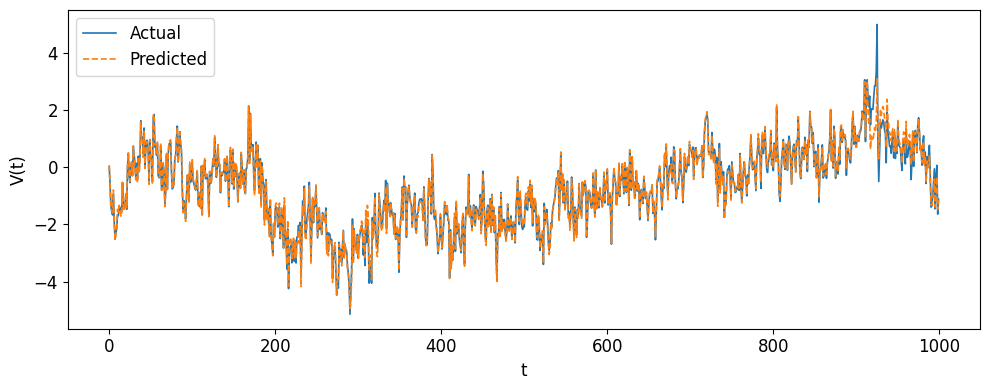

Baseline MSE: 0.03463826652225279


In [ ]:
S_  = torch.tensor(S, dtype=torch.float32)
V_ = torch.tensor(V, dtype=torch.float32)

input_data = np.stack([t, W, B], axis=1)
X = torch.tensor(input_data, dtype=torch.float32)

path = np.stack([t, W, B], axis=1)
X1 = np.array([iisignature.sig(path[0:i], 3) for i in range(1,len(path)+1)])

median = np.median(X1, axis=0)
iqr = np.percentile(X1, 75, axis=0) - np.percentile(X1, 25, axis=0) + 1e-8
S_robust = (X1 - median) / iqr
X1 = S_robust


print(X1.shape)
clf = linear_model.LinearRegression()
clf.fit(X1, V_)
y_hat1 = clf.intercept_
for i in range(len(clf.coef_)):
  y_hat1 = y_hat1 + clf.coef_[i]*X1[:,i]

TITLE_FONTSIZE  = 14
LABEL_FONTSIZE  = 12
TICK_FONTSIZE   = 12
LEGEND_FONTSIZE = 12

plt.figure(figsize=(10,4))
plt.plot(V_, label="Actual", linewidth=1.2, alpha=1.0, zorder=1)
plt.plot(y_hat1, label="Predicted", linewidth=1.2, alpha=1.0, zorder=2, linestyle="--")
plt.xlabel("t", fontsize=LABEL_FONTSIZE)
plt.ylabel("V(t)", fontsize=LABEL_FONTSIZE)
plt.xticks(fontsize=TICK_FONTSIZE)
plt.yticks(fontsize=TICK_FONTSIZE)
plt.legend(fontsize=LEGEND_FONTSIZE)
plt.tight_layout()
plt.savefig("Approximating_volatility_without_extended_path.png", bbox_inches=None, dpi=300)
plt.show()
MSE = mean_squared_error(V_, y_hat1)
print("Baseline MSE:", MSE)

In [ ]:
class Path_extension(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Path_extension, self).__init__()
        hidden_dims = [512, 256, 128, 64, 32, 16]
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
        self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
        self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
        self.out = nn.Linear(hidden_dims[5], output_dim)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        x = self.act(self.fc6(x))
        return self.out(x)

###Shuffle Loss Function

In [ ]:
def shuffle_loss_function(X_bar):
    dX = X_bar[1:, :] - X_bar[:-1, :]
    X_left = X_bar[:-1, :]
    I = torch.einsum('ka,kb->ab', X_left, dX)
    deltas = X_bar[-1, :] - X_bar[0, :]
    R = deltas[:, None] * deltas[None, :] - (I + I.T)
    return torch.triu(R.pow(2), diagonal=0).sum()


def shuffle_loss_residual(X_bar):
    dX = X_bar[1:, :] - X_bar[:-1, :]
    X_left = X_bar[:-1, :]
    I = torch.einsum('ka,kb->ab', X_left, dX)
    deltas = X_bar[-1, :] - X_bar[0, :]
    R = deltas[:, None] * deltas[None, :] - (I + I.T)
    return R

In [ ]:
def based_path(Z: torch.Tensor):
    return Z - Z[:1, :]

def levels_1_2_3_left(Z: torch.Tensor):
    Z = based_path(Z)
    dZ = Z[1:] - Z[:-1]
    Z_left = Z[:-1]
    S1 = Z[-1] - Z[0]
    outer2 = Z_left.unsqueeze(2) * dZ.unsqueeze(1)
    S2 = outer2.sum(dim=0)
    prefix2 = outer2.cumsum(dim=0)
    prefix2_left = torch.cat([torch.zeros_like(prefix2[:1]), prefix2[:-1]], dim=0)
    S3 = torch.einsum("kab,kc->abc", prefix2_left, dZ)
    return S1, S2, S3

In [ ]:
def shuffle_loss_11(S1, S2):
    R = S1[:, None] * S1[None, :] - (S2 + S2.T)
    return torch.triu(R.pow(2), diagonal=0).sum()

In [ ]:
def shuffle_loss_12(S1, S2, S3):
    lhs = S1[:, None, None] * S2[None, :, :]
    rhs = S3 + S3.permute(1, 0, 2) + S3.permute(1, 2, 0)
    R = lhs - rhs
    return R.pow(2).mean()

In [ ]:
def shuffle_loss_111(S1, S3):
    lhs = S1[:, None, None] * S1[None, :, None] * S1[None, None, :]
    rhs = (
        S3 +
        S3.permute(0,2,1) +
        S3.permute(1,0,2) +
        S3.permute(1,2,0) +
        S3.permute(2,0,1) +
        S3.permute(2,1,0)
    )
    R = lhs - rhs
    return R.pow(2).mean()

In [ ]:
epochs        = 1000
lr            = 1e-3
sig_depth1    = 3
sig_depth2    = 3
lambda_1   = 10.0
lambda_2  = 1.0

device = X.device
N1, d1 = X.shape                  #shape of the input data
model   = Path_extension(input_dim=3, output_dim=12).to(device)
d2 = model(X).shape[1]            #output dimension from the extension
d3 = d1 + d2                      #dimension of the concatenation of actual path and the extension
d4 = signatory.signature_channels(d3, depth=sig_depth1) #number of components of the signature
linear1 = nn.Linear(d4, 1, bias=False).to(device) #first linear layer
d5 = d1 + 1                       #input for the second signature
d6 = signatory.signature_channels(d5, depth=sig_depth2)
linear2 = nn.Linear(d6, 1, bias=False).to(device) #second linear layer

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(linear1.parameters()) + list(linear2.parameters()),
    lr=lr
)
mse = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

##Training

In [ ]:
error_array = []
shuffle_loss_11_array = []
shuffle_loss_12_array = []
shuffle_loss_111_array = []
shuffle_loss_array = []
for epoch in tqdm(range(1, epochs + 1)):
  model.train(); linear1.train(); linear2.train()
  optimizer.zero_grad()
  out1 = model(X)

  S1, S2, S3 = levels_1_2_3_left(out1)
  loss11 = shuffle_loss_11(S1, S2)
  loss12 = shuffle_loss_12(S1, S2, S3)
  loss111 = shuffle_loss_111(S1, S3)
  shuffle_loss_11_array.append(loss11.item())
  shuffle_loss_12_array.append(loss12.item())
  shuffle_loss_111_array.append(loss111.item())
  shuffle_loss = loss11 + loss12 + loss111
  shuffle_loss_array.append(shuffle_loss.item())

  stack1 = torch.cat([X.unsqueeze(0), out1.unsqueeze(0)], dim=2)
  sig1 = signatory.signature(stack1, depth=sig_depth1, basepoint=True, stream=True)

  median = torch.quantile(sig1, 0.5, dim=1)
  iqr = torch.quantile(sig1, 0.75, dim=1) - torch.quantile(sig1, 0.25, dim=1) + 1e-8
  S_robust = (sig1 - median) / iqr
  sig1 = S_robust


  pred1 = linear1(sig1)
  stack2 = torch.cat([X.unsqueeze(0), pred1], dim=2)
  sig2 = signatory.signature(stack2, depth=sig_depth2, basepoint=True, stream=True)

  median = torch.quantile(sig2, 0.5, dim=1)
  iqr = torch.quantile(sig2, 0.75, dim=1) - torch.quantile(sig2, 0.25, dim=1) + 1e-8
  S_robust = (sig2 - median) / iqr
  sig2 = S_robust

  pred2 = linear2(sig2)
  error1 = mse(pred2.squeeze(-1), V_.unsqueeze(0))
  error_array.append(error1.item())
  Final_error = lambda_1*error1 + lambda_2*shuffle_loss
  Final_error.backward()
  optimizer.step()
  scheduler.step()

100%|██████████| 1000/1000 [26:24<00:00,  1.58s/it]


In [ ]:
print(error_array[-1])
print(shuffle_loss_array[-1])

0.7486752867698669
0.2425520420074463


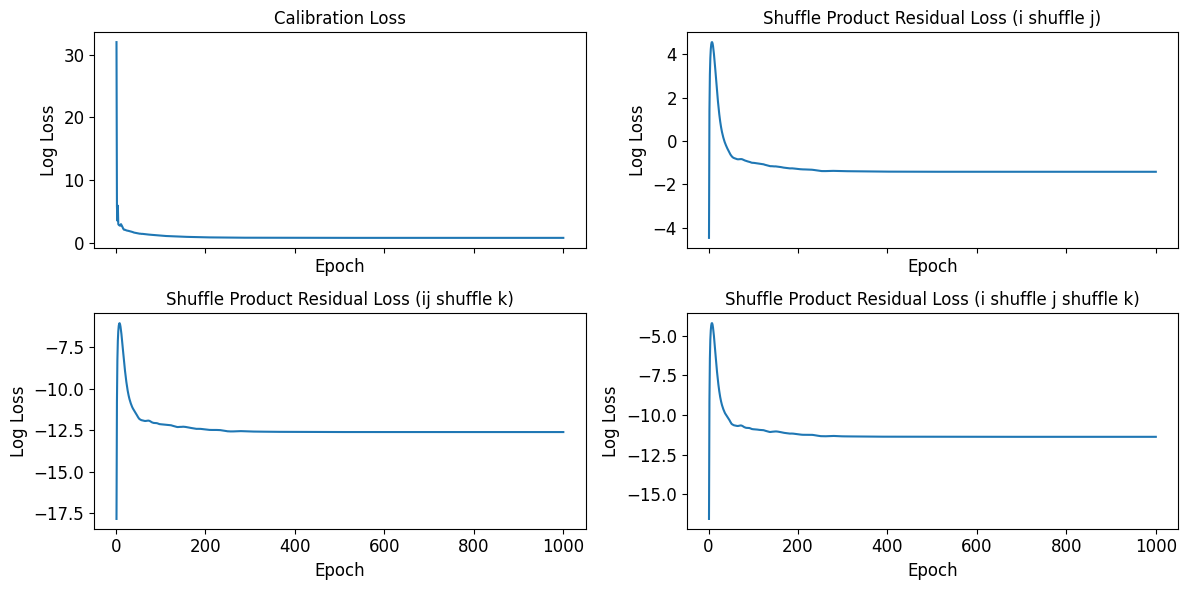

In [ ]:
epochs_axis = np.arange(1, len(error_array) + 1)
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
eps = 1e-12
axs[0,0].plot(epochs_axis, error_array)
axs[0,0].set_title(r"Calibration Loss", fontsize=LABEL_FONTSIZE)
axs[0,0].set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
axs[0,0].set_ylabel("Log Loss", fontsize=LABEL_FONTSIZE)
axs[0,0].grid(False)

axs[0,1].plot(epochs_axis, np.log(np.maximum(shuffle_loss_11_array,eps)))
axs[0,1].set_title(r"Shuffle Product Residual Loss (i shuffle j)", fontsize=LABEL_FONTSIZE)
axs[0,1].set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
axs[0,1].set_ylabel("Log Loss", fontsize=LABEL_FONTSIZE)
axs[0,1].grid(False)

axs[1,0].plot(epochs_axis, np.log(np.maximum(shuffle_loss_12_array,eps)))
axs[1,0].set_title(r"Shuffle Product Residual Loss (ij shuffle k)", fontsize=LABEL_FONTSIZE)
axs[1,0].set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
axs[1,0].set_ylabel("Log Loss", fontsize=LABEL_FONTSIZE)
axs[1,0].grid(False)

axs[1,1].plot(epochs_axis, np.log(np.maximum(shuffle_loss_111_array,eps)))
axs[1,1].set_title(r"Shuffle Product Residual Loss (i shuffle j shuffle k)", fontsize=LABEL_FONTSIZE)
axs[1,1].set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
axs[1,1].set_ylabel("Log Loss", fontsize=LABEL_FONTSIZE)
axs[1,1].grid(False)

for ax in axs.ravel():
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)

fig.tight_layout()
fig.savefig("losses_vs_epoch.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
with torch.no_grad():
    X_bar = model(X)
    shuffle_loss = shuffle_loss_residual(X_bar)
    R = shuffle_loss.detach().cpu().numpy()
    C = R.shape[0]
    v = abs(R).max() + 1e-12

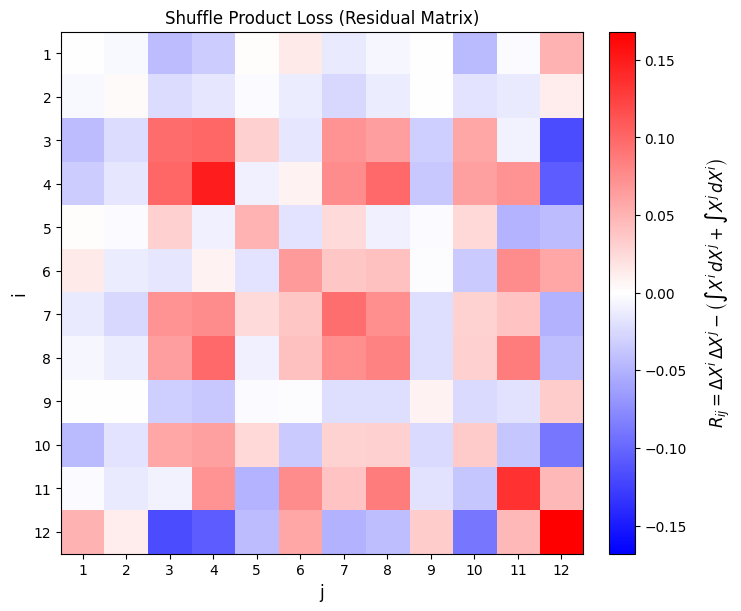

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
im = ax.imshow(R, cmap="bwr", vmin=-v, vmax=v, interpolation="nearest", aspect="equal")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"$R_{ij}=\Delta X^i\,\Delta X^j - \left(\int X^i\,dX^j + \int X^j\,dX^i\right)$",
               rotation=90, labelpad=12, fontsize=LABEL_FONTSIZE)
ax.set_title("Shuffle Product Loss (Residual Matrix)", fontsize=LABEL_FONTSIZE)
ax.set_xlabel("j", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("i", fontsize=LABEL_FONTSIZE)
positions = np.arange(C)
labels = [str(i) for i in range(1, C+1)]
ax.set_xticks(positions); ax.set_xticklabels(labels)
ax.set_yticks(positions); ax.set_yticklabels(labels)
ax.set_xlim(-0.5, C-0.5); ax.set_ylim(C-0.5, -0.5)
fig.savefig("shuffle_product_loss_heatmap.png", bbox_inches="tight", pad_inches=0.03, dpi=300)
plt.show()

In [ ]:
output = model(X)
stack11 = torch.cat([X.unsqueeze(0), output.unsqueeze(0)], dim=2)
sig11 = signatory.signature(stack11, depth=3, basepoint=True, stream=True)
X_feat = sig11.squeeze(0).detach().numpy()
clf2 = linear_model.LinearRegression()
clf2.fit(X_feat, V_)
y_hat2 = clf2.predict(X_feat)

In [ ]:
y = V_.detach().cpu().numpy()

/tmp/ipython-input-3263905775.py:25: MatplotlibDeprecationWarning: Since Matplotlib 3.10 indicate_inset_[zoom] returns a single InsetIndicator artist with a rectangle property and a connectors property.  From 3.12 it will no longer be possible to unpack the return value into two elements.
  for c in con:
/tmp/ipython-input-3263905775.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


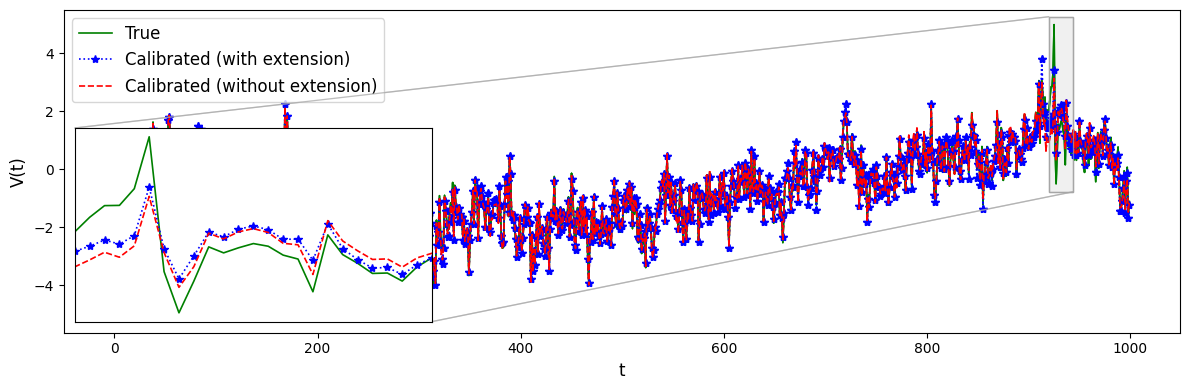

In [ ]:
start, window = 920, 25
x0, x1 = start, start + window - 1

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y,     label='True', linewidth=1.2, color='g')
ax.plot(y_hat2, label='Calibrated (with extension)', linewidth=1.2, linestyle=":",  marker='*', color='b')
ax.plot(y_hat1,   label='Calibrated (without extension)', linewidth=1.2, linestyle="--", color='r')

axins = inset_axes(ax, width="32%", height="60%",
                   loc="lower left", borderpad=0.8)
axins.plot(y,     linewidth=1.2, color='g')
axins.plot(y_hat2, linewidth=1.2, linestyle=":", marker='*', color='b')
axins.plot(y_hat1,   linewidth=1.2, linestyle="--", color='r')

axins.set_xlim(x0, x1)
ymin = min(y[x0:x1+1].min(), y_hat2[x0:x1+1].min(), y_hat1[x0:x1+1].min())
ymax = max(y[x0:x1+1].max(), y_hat2[x0:x1+1].max(), y_hat1[x0:x1+1].max())
pad = 0.05 * (ymax - ymin + 1e-12)
axins.set_ylim(ymin - pad, ymax + pad)
axins.set_xticks([]); axins.set_yticks([])

try:
    con = ax.indicate_inset_zoom(axins, edgecolor="0.65")
    try:
        for c in con:
            c.set_alpha(0.7); c.set_linewidth(0.9)
    except TypeError:
        con.set_alpha(0.7); con.set_linewidth(0.9)
except AttributeError:
    ret = mark_inset(ax, axins, loc1=2, loc2=4, fc='0.94', ec='0.65')
    if isinstance(ret, tuple) and len(ret) == 3:
        patch, p1, p2 = ret
        for c in (p1, p2):
            c.set_alpha(0.7); c.set_linewidth(0.9)
    else:
        patch, connectors = ret
        for c in (connectors if isinstance(connectors, (list, tuple)) else [connectors]):
            c.set_alpha(0.7); c.set_linewidth(0.9)

l_true,  = ax.plot(y,     label='True', linewidth=1.2, color='g')
l_ext,   = ax.plot(y_hat2, label='Calibrated (with extension)', linewidth=1.2, linestyle=":", marker='*', color='b')
l_noext, = ax.plot(y_hat1,   label='Calibrated (without extension)', linewidth=1.2, linestyle="--", color='r')
ax.set_xlabel("t", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("V(t)", fontsize=LABEL_FONTSIZE)
ax.legend(handles=[l_true, l_ext, l_noext], fontsize=LEGEND_FONTSIZE)
fig.tight_layout()
fig.savefig("calibrated_volatility_path_zoom.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(mean_squared_error(V_, y_hat2))
print(mean_squared_error(V_, y_hat1))

0.029359260573983192
0.03463826652225279


In [ ]:
y1 = S_.detach().cpu().numpy()
clf3 = linear_model.LinearRegression()
clf3.fit(X_feat, S_)
y2 = clf3.predict(X_feat)
clf3 = linear_model.LinearRegression()
clf3.fit(X1, S_)
y3 = clf3.predict(X1)

/tmp/ipython-input-3120038691.py:24: MatplotlibDeprecationWarning: Since Matplotlib 3.10 indicate_inset_[zoom] returns a single InsetIndicator artist with a rectangle property and a connectors property.  From 3.12 it will no longer be possible to unpack the return value into two elements.
  for c in con:
/tmp/ipython-input-3120038691.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


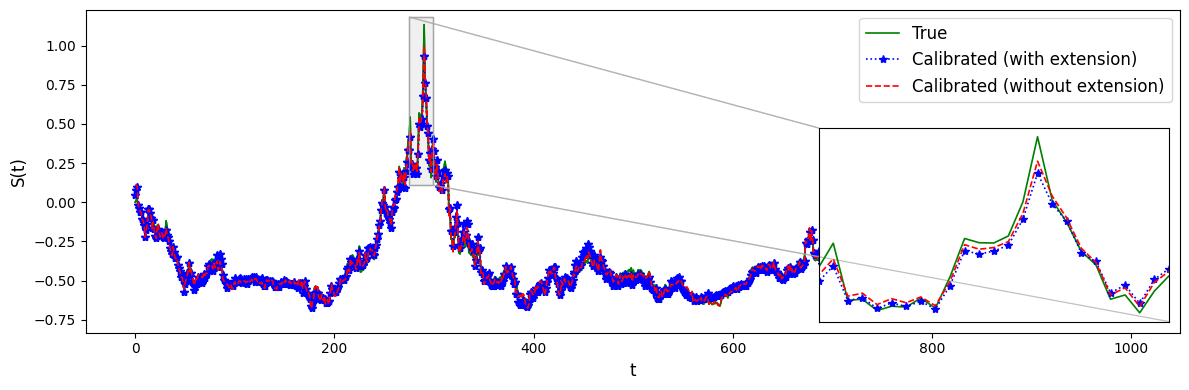

In [ ]:
start, window = 275, 25
x0, x1 = start, start + window - 1
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y1,     label='True', linewidth=1.2, color='g')
ax.plot(y2, label='Calibrated (with extension)', linewidth=1.2, linestyle=":", marker='*', color='b')
ax.plot(y3,   label='Calibrated (without extension)', linewidth=1.2, linestyle="--", color='r')
axins = inset_axes(ax, width="32%", height="60%",   # <— make this larger/smaller
                   loc="lower right", borderpad=0.8)

axins.plot(y1,     linewidth=1.2, color='g')
axins.plot(y2, linewidth=1.2, linestyle=":", marker='*', color='b')
axins.plot(y3,   linewidth=1.2, linestyle="--", color='r')

axins.set_xlim(x0, x1)
ymin = min(y1[x0:x1+1].min(), y2[x0:x1+1].min(), y3[x0:x1+1].min())
ymax = max(y1[x0:x1+1].max(), y2[x0:x1+1].max(), y3[x0:x1+1].max())
pad = 0.05 * (ymax - ymin + 1e-12)
axins.set_ylim(ymin - pad, ymax + pad)
axins.set_xticks([]); axins.set_yticks([])

try:
    con = ax.indicate_inset_zoom(axins, edgecolor="0.65")
    try:
        for c in con:
            c.set_alpha(0.7); c.set_linewidth(0.9)
    except TypeError:
        con.set_alpha(0.7); con.set_linewidth(0.9)
except AttributeError:
    ret = mark_inset(ax, axins, loc1=2, loc2=4, fc='0.94', ec='0.65')
    if isinstance(ret, tuple) and len(ret) == 3:
        patch, p1, p2 = ret
        for c in (p1, p2):
            c.set_alpha(0.7); c.set_linewidth(0.9)
    else:
        patch, connectors = ret
        for c in (connectors if isinstance(connectors, (list, tuple)) else [connectors]):
            c.set_alpha(0.7); c.set_linewidth(0.9)

l_true,  = ax.plot(y1,     label='True', linewidth=1.2, color='g')
l_ext,   = ax.plot(y2, label='Calibrated (with extension)', linewidth=1.2, linestyle=":", marker='*', color='b')
l_noext, = ax.plot(y3,   label='Calibrated (without extension)', linewidth=1.2, linestyle="--", color='r')
ax.set_xlabel("t", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("S(t)", fontsize=LABEL_FONTSIZE)
ax.legend(handles=[l_true, l_ext, l_noext], fontsize=LEGEND_FONTSIZE)
fig.tight_layout()
fig.savefig("calibrated_stock_path_zoom.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(mean_squared_error(y1, y2))
print(mean_squared_error(y1, y3))

0.0008423677645623684
0.0005242939459691831
